In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.SpaceMMiCRM, MLSolver

Precompiling packages...
  27547.0 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 33 seconds. 480 already precompiled.


In [2]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools
using JLD2, Geppetto

In [3]:
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# ODE/PDE Solving

## Basic no space solve

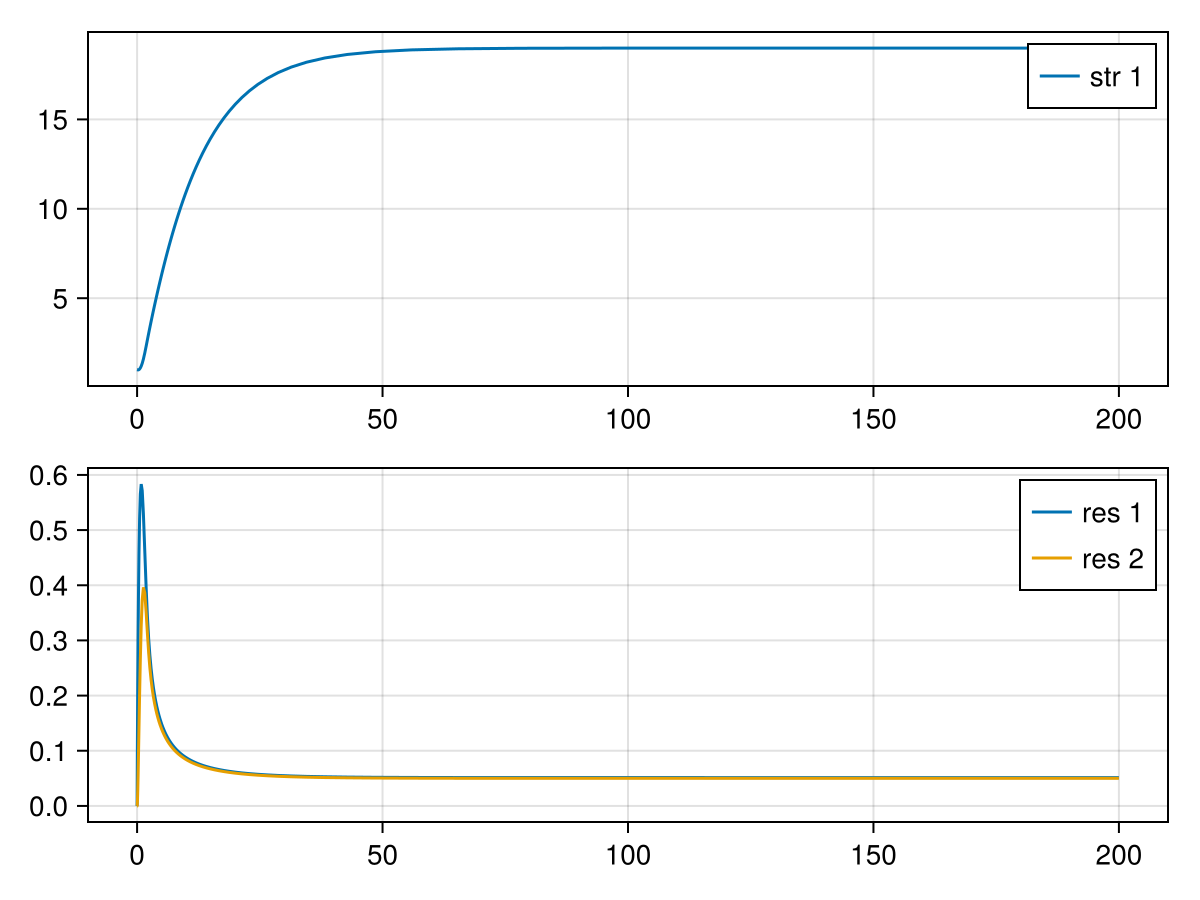

3-element Vector{Float64}:
 18.986817201996566
  0.05131674360473515
  0.05000003961685623

In [50]:
D = fill(0., 1, 2, 2)
D[1, 2, 1] = 1.
c = [2. 2.]
l = [1. 0.]

p = make_mmicrm_smart(1, 2, 200;
    D, c, l,
    K=[2., 0.],
    r=[1., 1.],
    m=[0.1],
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
check_mmicrmparams(p.p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

In [58]:
s.u[end]

3-element Vector{Float64}:
 18.986817201996566
  0.05131674360473515
  0.05000003961685623

In [62]:
solve(SteadyStateProblem(p), DynamicSS())

retcode: Success
u: 3-element Vector{Float64}:
 18.98666214934115
  0.05131715292462866
  0.050000428909981756

## Linear stability analysis

In [5]:
usol = s.u[end]
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[1.5043960145658643e-6, -4.054400148945092e-9, -3.762862466061279e-9]

maximum(real(lambdas)) = 0.001883153838108191


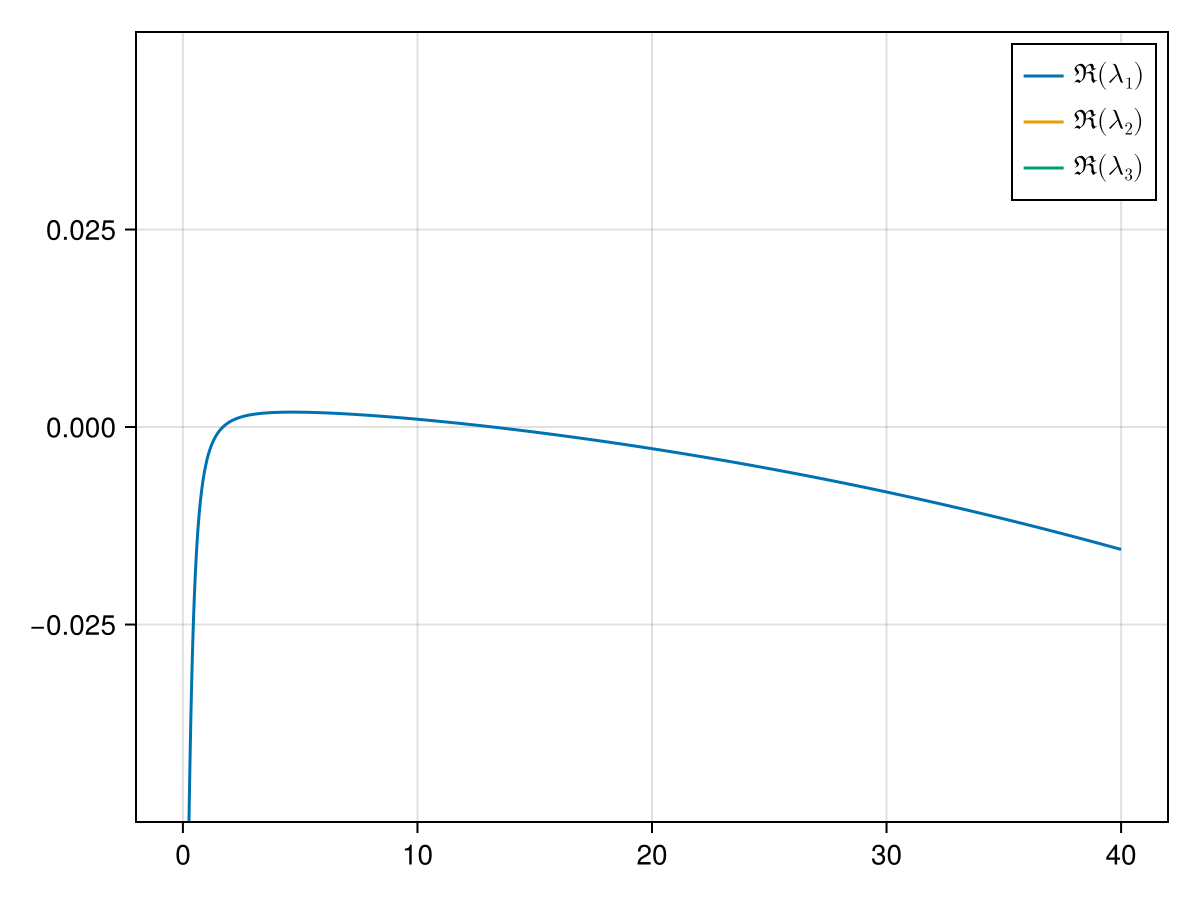

In [6]:
ks = LinRange(0., 40., 10000)
Ds = [1e-5, 500, 0.1]

lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.05, 0.05))
# xlims!(faa.axis, (0., 2.))
faa

In [7]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(1167, 4.664466446644664)

In [8]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
 -0.999999998425741
  9.400737817253314e-6
 -5.5318567907767844e-5

## Spatial stuff - 1D!

In [155]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.01, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.01]))

#### Direct solver

In [156]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

  1.800528 seconds (667.92 k allocations: 645.405 MiB, 4.46% gc time)
Success
nf is 3370
solution has 512 saved states
max resid is 6.06115e-06


┌ Warning: reaching negative values, minimum is -2.66875e-06
└ @ SSMCMain.SpaceMMiCRM ~/Sync/University/PhD/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/smmicrm_util.jl:10


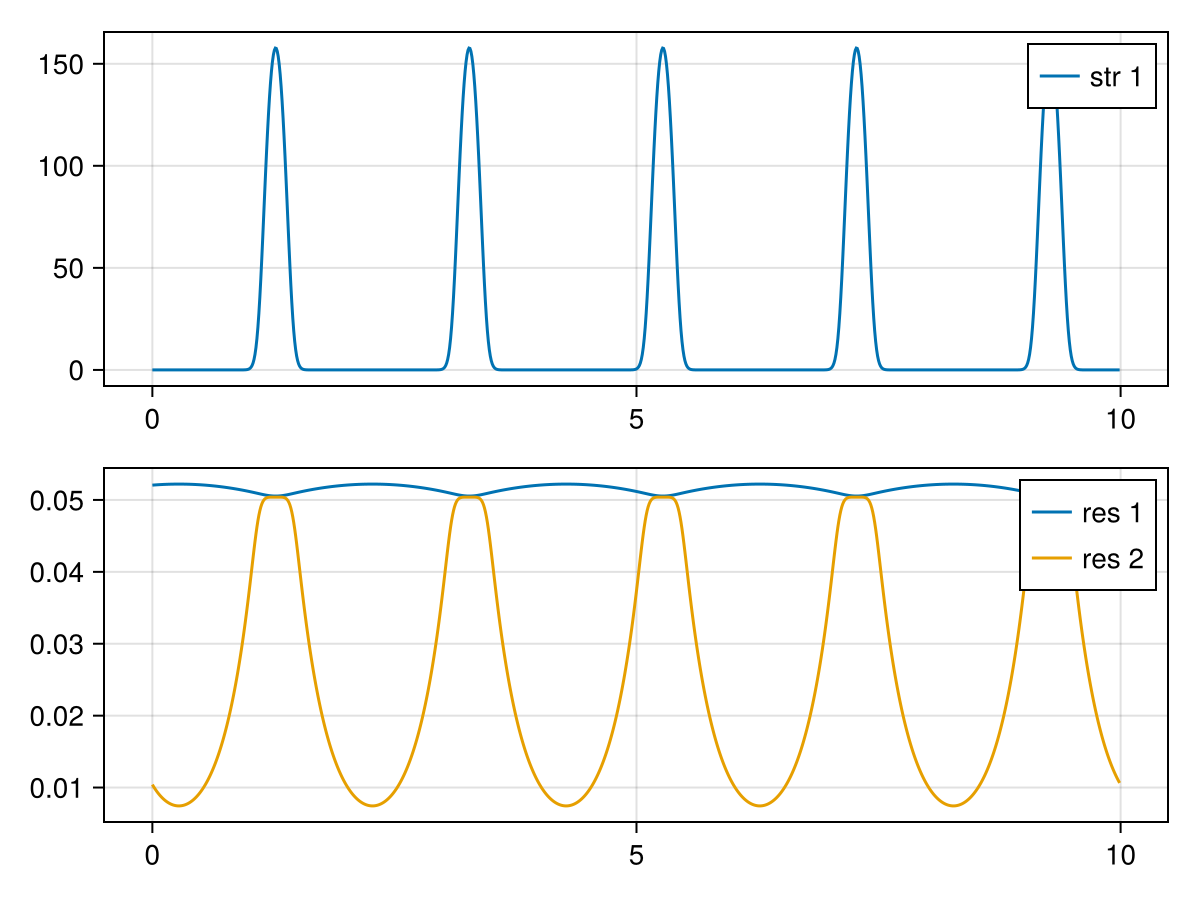

In [157]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))

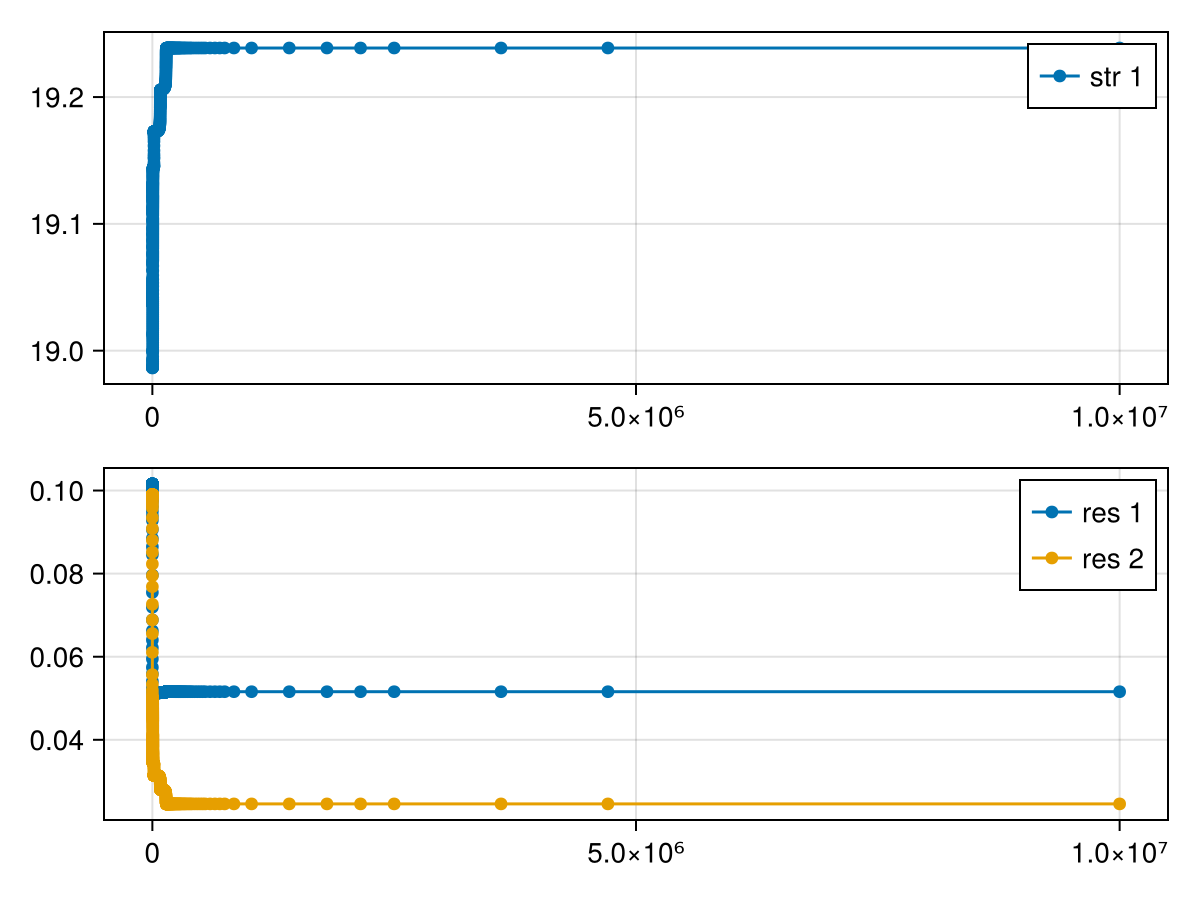

In [158]:
plot_smmicrm_sol_avgs(sps)

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

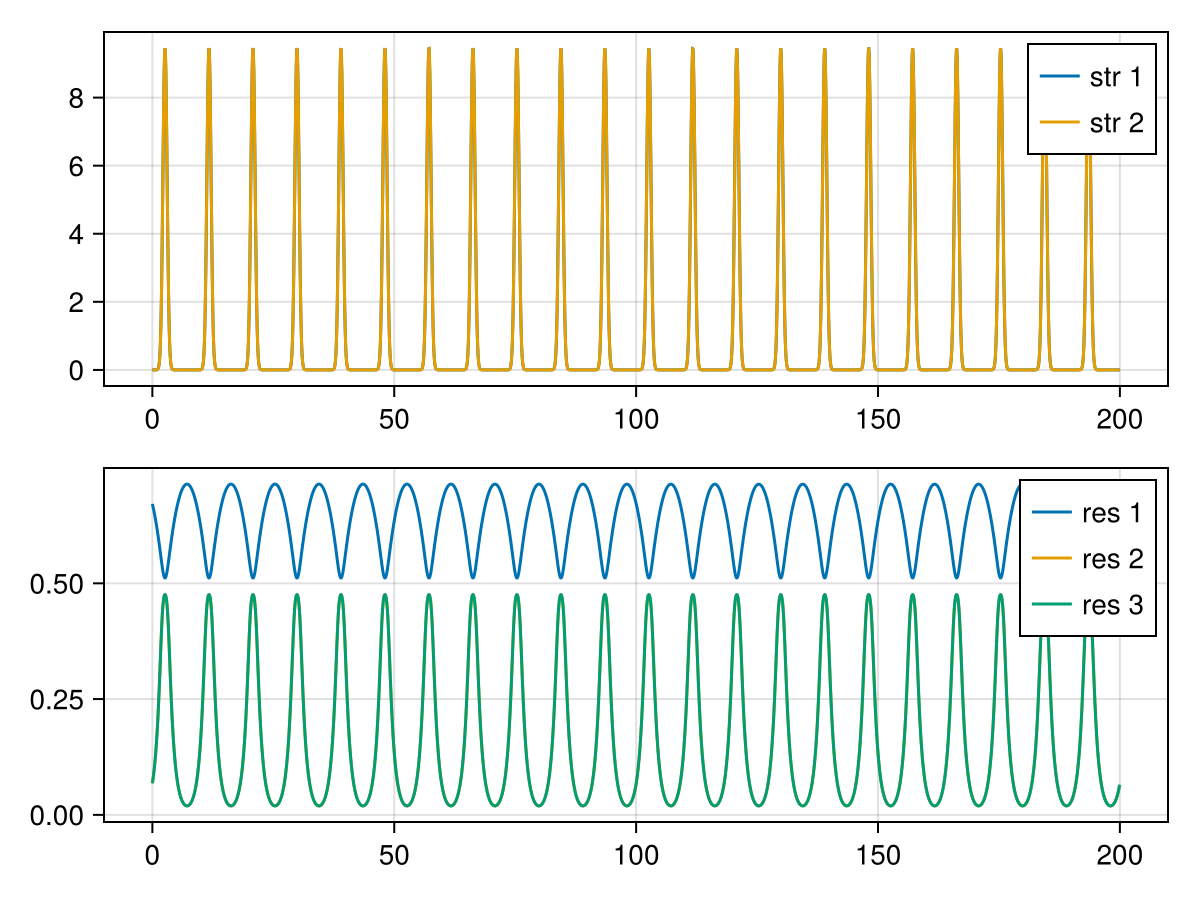

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [159]:
ssize = (60,60)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.1, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 60, 60), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]))

### Direct solver

In [160]:
@time sps = solve(sp, QNDF(); maxiters=10000)
print_spatial_solution_stats(sps)

 43.717454 seconds (722.00 k allocations: 6.361 GiB, 0.45% gc time)
Success
nf is 3228
solution has 421 saved states
max resid is 4.58766e-08


┌ Warning: reaching negative values, minimum is -1.20973e-05
└ @ SSMCMain.SpaceMMiCRM ~/Sync/University/PhD/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/smmicrm_util.jl:10


### Plotting sps

In [8]:
sps.prob.p

SMMiCRMParams{1, 2, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}, Float64, 3, Int64, 2, 4}(MMiCRMParams{1, 2, Float64, 2, 4}([1.0], [1.0, 1.0], [0.1], [1.0, 0.0], [1.0, 1.0], [1.0 0.0], [1.0 1.0], [0.0 1.0;;; 0.0 0.0]), [1.0e-5, 5.0, 1.0], CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]), 18)

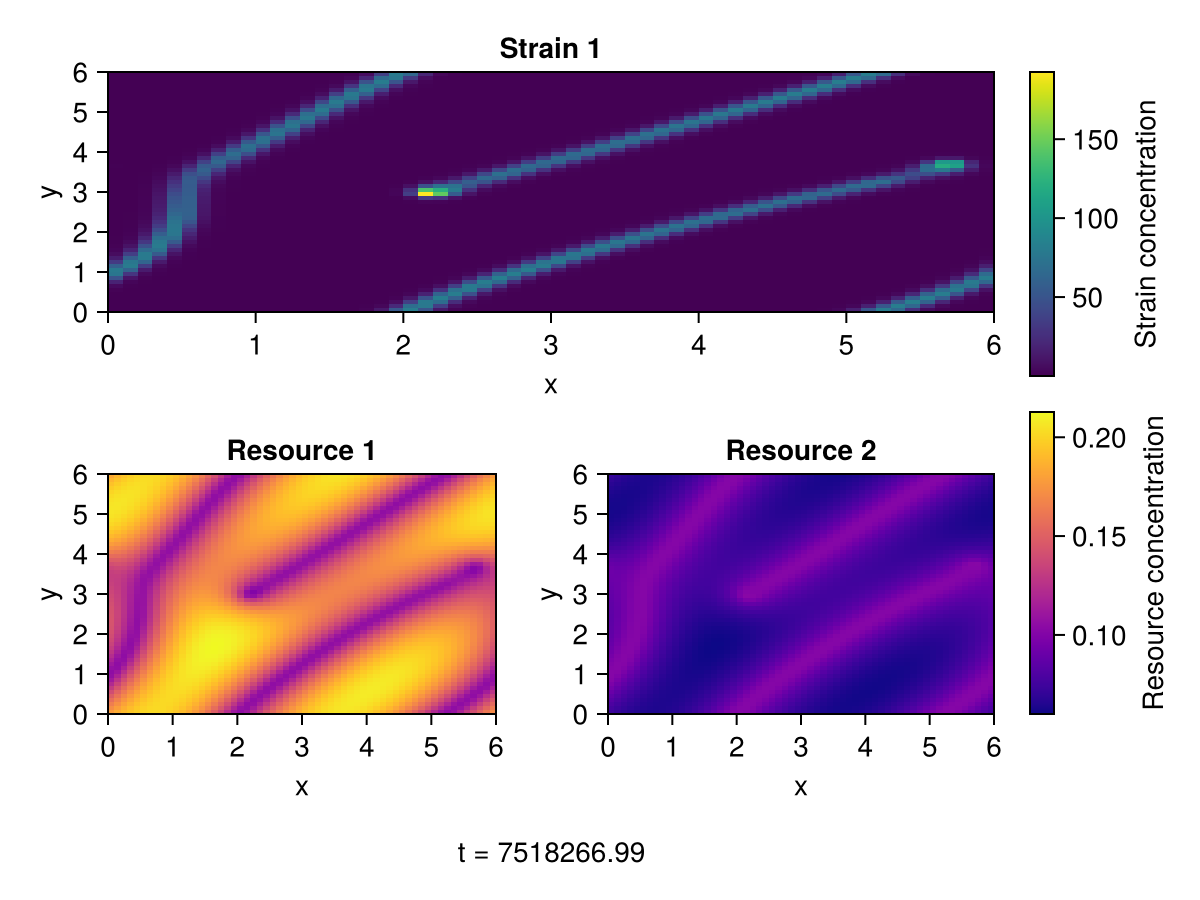

In [65]:
f = plot_2dsmmicrm_sol_snap_heatmap(sps, -1)

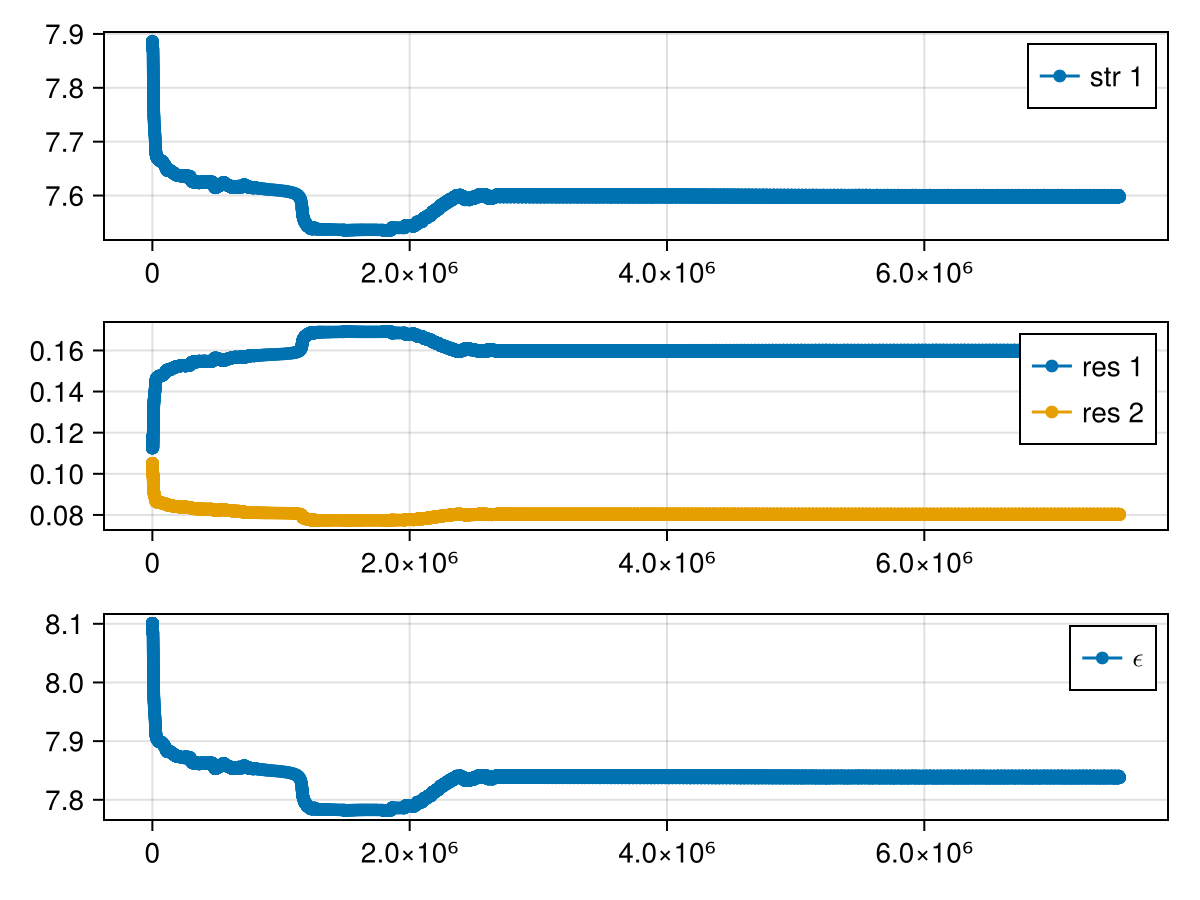

In [6]:
f = plot_smmicrm_sol_avgs(sps; plote=true)
#display(GLMakie.Screen(), f)

In [68]:
f = plot_2dsmmicrm_sol_interactive_heatmap(sps)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

## Saving/loading

In [240]:
save_object(datadir("minimalmodel", randname()*".jld2"), sps)

In [4]:
sps = load_object("../data/minimalmodel/fascinating_maybe_moving.jld2");
print_spatial_solution_stats(sps)

MaxIters
nf is 110126
solution has 8608 saved states
max resid is 0.00431203


### Running for longer

In [40]:
sps.t[begin], sps.t[end]

(0.0, 7.518266985339596e6)

In [41]:
old_sps = copy(sps)
e_sp = extend_solprob(sps, 1000000)
@time sps = solve(e_sp, QNDF(); maxiters=10000)
print_spatial_solution_stats(sps)

 78.418038 seconds (2.69 M allocations: 28.764 GiB, 11.49% gc time, 0.01% compilation time)
Success
nf is 16959
solution has 1298 saved states
max resid is 0.00267749


In [212]:
display(GLMakie.Screen(), plot_2dsmmicrm_sol_interactive_heatmap(sps))

GLMakie.Screen(...)

### Adding more noise (and time of course)

In [296]:
u = sps.u[end]
linear_interpolation(CartesianIndices(u), u)

LoadError: MethodError: no method matching linear_interpolation(::CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}, ::Array{Float64, 3})

[0mClosest candidates are:
[0m  linear_interpolation([91m::Tuple{Vararg{AbstractRange, N}}[39m, ::AbstractArray{T, N}; extrapolation_bc) where {N, T}
[0m[90m   @[39m [36mInterpolations[39m [90m~/.julia/packages/Interpolations/91PhN/src/[39m[90m[4mconvenience-constructors.jl:22[24m[39m
[0m  linear_interpolation([91m::Tuple{Vararg{AbstractVector, N}}[39m, ::AbstractArray{T, N}; extrapolation_bc) where {N, T}
[0m[90m   @[39m [36mInterpolations[39m [90m~/.julia/packages/Interpolations/91PhN/src/[39m[90m[4mconvenience-constructors.jl:25[24m[39m


In [238]:
pu0 = perturb_u0_uniform_prop(get_Ns(sps.prob.p)..., sps.u[end], 0.05)
e_sp = remake(sps.prob; u0=pu0, tspan=(sps.t[end], 1.5*(sps.t[end] - sps.t[begin])));
@time sps = solve(e_sp, QNDF(); maxiters=10000)
print_spatial_solution_stats(sps)

355.676942 seconds (9.78 M allocations: 107.991 GiB, 20.23% gc time)
Success
nf is 63826
solution has 4963 saved states
max resid is 0.00290947


### Doubling the sampling

# Extras

In [305]:
empty!(Out)
GC.gc()